# Active Learning Experiment Notebook

##### TODO
if using autooracle, want 
- visualization of what the oracle is seeing/saying

in general want
- training curves (make sure to maintain a history from initial training)

convergence criterion? 

##### TODO_csplus
- Restructure the input to the discriminator, from ground-truth images to output from initial segmenter ✅
- Use ground-truth images for segmenter training instead of manually thresholded images.
    - Change auto_oracle.py
- Edit experiment.py to follow the revised model, and enable image stacking to allow a full AL loop
- Once the model is fully well-structured, evaluate performance with various tunable parameters

In [1]:
#Python Library imports
import random
import torch 
import numpy as np
import glob
import os
import datetime 


#Backend py file imports
from dataloader import get_DataLoader
from disc_model import disc_model

from auto_oracle import query_oracle_automatic
# from manual_oracle import query_oracle

from experiment import save_active_learning_results, remove_bad_oracle_results
from experiment import update_dir_with_oracle_info, redirect_saved_oracle_filepaths_to_thresheld_directory, save_files_for_nnunet

from nnunet_model import convert_2d_image_to_nifti, plan_and_preprocess
import nnunet_model
import unet_model

%matplotlib inline



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet



### Seed all Random Generators

In [2]:
random_seed_number = 44
import numpy
import medpy

torch.manual_seed(random_seed_number)
torch.cuda.manual_seed(random_seed_number)
np.random.seed(random_seed_number)
random.seed(random_seed_number)

torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

### Run ID Setup / Tunable Parameters

This section will set up a run_id to identify each run and a save folder to save data to. 

In [3]:
# PARAMETERS: Set some initial tunable parameters
QUERY_METHOD = "worst" # 'worst' 'best' 'uniform' 'random' 'percentile=0.x'
NUM_IMAGES_QUERIED = 100 
BATCH_SIZE_INIT = 32 # Initial: 32
INITIAL_DISCRIMINATOR_EPOCHS = 1 # Initial: 10
UPDATE_DISCRIMINATOR_EPOCHS = 1 # Initial: 10
SEGMENTER_UPDATE_EPOCHS_INIT = 5 # Initial: 5

In [4]:
#run_id has format of "yy_mm_dd", and iter_num is the current run on the day (0,1,2,etc)
run_id = datetime.date.today().strftime("%y_%m_%d")
iter_num = input("which iteration is this of the day? ")

# Where do you want to save all outputs?
output_dir = "/usr/xtmp/sc834/mammoproj/nnunet_integration_tmp/AllOracleRuns"
run_dir = os.path.join(output_dir, "Run_" + run_id, "Iter" + str(iter_num))

print("run_id: ", run_id, "\n"
      "iter_num: ", iter_num, "\n"
      "AL Query Method: ", QUERY_METHOD, "\n"
      "# images queried: ", NUM_IMAGES_QUERIED, "\n"
      "Initial batch size for discriminator: ", BATCH_SIZE_INIT, "\n"
      "Initial discriminator training # epochs", INITIAL_DISCRIMINATOR_EPOCHS, "\n"
      "Updating discriminator # epochs: ", UPDATE_DISCRIMINATOR_EPOCHS, "\n"
      "Update segmenter # epochs: ", SEGMENTER_UPDATE_EPOCHS_INIT)

run_id:  23_06_26 
iter_num:  13 
AL Query Method:  worst 
# images queried:  100 
Initial batch size for discriminator:  32 
Initial discriminator training # epochs 1 
Updating discriminator # epochs:  1 
Update segmenter # epochs:  5


In [5]:
#users_name tells us who is working on the notebook (vaibhav/alina/julia)
users_name = input("what is your name: ")
print(f"Your name is: {users_name}.")

Your name is: sangwook.


## Active Learning Stage

### Set Image Directories

This section sets up directories for the active learning. We will need a directory of images for training the discriminator, a directory that the oracle will query from, and a directory that has the ground truth segmentations.

All files within the directories should be .npy and have shape (2, r, c) where the first channel is the original image, and the second channel is the binarized segmentation. 

In [6]:
discriminator_training_dir = "/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/" 
oracle_query_dir = "/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/"
ground_truth_dir = "/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/"

### Initial Discriminator Training

In this section, we initialize the discriminator by training a VGG11 network to discriminate between "good" segmentations (labeled `1`) and "bad" segmentations (labeled `0`). The data for training comes from the `discriminator_training_dir` specified [above](#Set-Image-Directories), but mismatches the (`image`, `segmentation`) pairs for half of each batch. The mismatched pairs get a label of `0`, the not mismatched pairs get a label of `1`.  

Parameters that can be tuned: 
- `batch_size`
- `init_disc_epochs` (number of epochs trained for initializing the discriminator)

Mismatch method can be found in the `disc_model.initialize_model` method. This method may also warrant tweaking.

In [7]:
# Generates dataloader to churn out batches of the images from discriminator_training_dir. 
# Takes in batch_size and num_workers
batch_size = BATCH_SIZE_INIT # TUNABLE PARAMETER

# Initially the images are 224, 224, but resized to 256, 256 in the get_DataLoader function
dataloader = get_DataLoader(discriminator_training_dir, batch_size, 2)

In [8]:
# instantiate, load, and initialize discriminator model by training N epochs (see disc_model.initialize_model for details)
## TODO: Pickle the model so that the same model can be reused for testing instead of retraining every time
discriminator = disc_model()
discriminator.load_model(dataloader) 

init_disc_epochs = INITIAL_DISCRIMINATOR_EPOCHS # TUNABLE PARAMETER 
discriminator.initialize_model(batch_size = batch_size, epochs=init_disc_epochs) # initial training


Using cache found in /home/users/sc834/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 26/26 [00:42<00:00,  1.62s/it]


#### Take a look at initial discriminator training performance

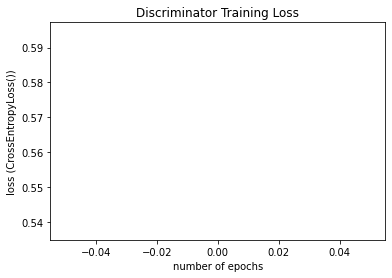

In [9]:
discriminator.plot_loss() ## TODO: should this be by epoch instead?... why was it by batch initially? 

  0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 26/26 [00:15<00:00,  1.65it/s]
/usr/project/xtmp/sc834/al/ActiveLearningShapes/path/to/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


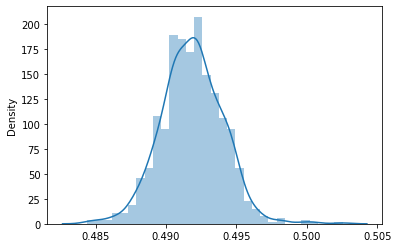

In [10]:
# Distribution - shows distribution of scores that show how 'good' the 
discriminator.plot_distribution(discriminator_training_dir)


In [11]:
## Show distribution of scores generated by the discriminator
# discriminator.show_disc(discriminator_training_dir)  

### Generating initial patient scores

Here, we get an score from the initialized discriminator for all (`image`, `segmentation`) pairs in the `oracle_query_dir`. The score indicates how good/bad the pair (low scores mean the segmentation does not match the image well, high scores mean the segmentation matches the image well). These scores will be used to choose which images to show the oracle. 

Note: it needs to use the same `batch_size` as above

In [12]:
# create a holder for all patient scores (this will be a list of dictionaries) 
all_patient_scores = [] 

## Updating AL Model Structure

### Load the initial segmenter model (pretrained on CBIS-DDSM)
This segmenter will produce predictions on the training data, which will be the input to the discriminator. 
The discriminator will then output results that show how good it thinks the segmentations are. 

In [13]:
# Produce segmentations by the initial segmenter, which will be input to discriminator, which will give a score.
# create files and record the directory to these segmentations

segmenter = nnunet_model.nnunet_model()
# segmenter_train_dir = os.path.join(os.environ['nnUNet_preprocessed'], f'Task{task_id}_{run_id}')
segmentation_folder = '/usr/xtmp/sc834/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/Task504_duke-mammo/imagesTr'
segmentation_save_dir = os.path.join(run_dir,"initial_segmentations")

segmenter.load_model("/usr/xtmp/sc834/mammoproj/data/nnUNet_preprocessed/Task501_cbis-ddsm")

print(segmentation_save_dir)

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2.nnUNetTrainerV2'>
For that I will be using the following configuration:
num_classes:  1
modalities:  {0: 'RGB'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 8, 'num_pool_per_axis': [7, 7], 'patch_size': array([640, 640]), 'median_patient_size_in_voxels': array([  1, 519, 518]), 'current_spacing': array([999.,   1.,   1.]), 'original_spacing': array([999.,   1.,   1.]), 'pool_op_kernel_sizes': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'conv_kernel_sizes': [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]], 'do_dummy_2D_data_aug': False}

I am using stage 0 from these plans
I am using batch dice + CE loss

I am using data from th

In [14]:
model_save_path = os.path.join(run_dir, 'all', "Iter" + str(iter_num)+".model")
segmenter.save_model(model_save_path)

2023-06-26 11:21:11.331197: saving checkpoint...
2023-06-26 11:21:12.091605: done, saving took 0.79 seconds


In [15]:
## NOTE: run this snippet only if need to create new predictions again. Otherwise, reuse the previous segmentations

# if not os.path.exists(segmentation_save_dir):
#     os.makedirs(segmentation_save_dir)

# if len(os.listdir(segmentation_save_dir)) == 0:
#     segmenter.predict(input_folder=segmentation_folder, output_folder=segmentation_save_dir)  

In [16]:
# Instead of running predict all the time, specify the path to initial_segmentations
# NOTE: This will not be possible during the actual AL loop, as the output from updated segmenter will produce different segmentations each time

previous_segmentation_save_dir = "/usr/xtmp/sc834/mammoproj/nnunet_integration_tmp/AllOracleRuns/Run_23_06_19/Iter4/initial_segmentations"

if os.path.exists(segmentation_save_dir):
    os.rmdir(segmentation_save_dir)

import shutil

# Copy the initial segmentations to the current task directory
shutil.copytree(previous_segmentation_save_dir, segmentation_save_dir)

'/usr/xtmp/sc834/mammoproj/nnunet_integration_tmp/AllOracleRuns/Run_23_06_26/Iter13/initial_segmentations'

### Convert initial predictions into numpy format
The initial output from the segmenter is in nii.gz format. These need to be converted into numpy images to be input to the discriminator

In [17]:
import nibabel as nib
import SimpleITK as sitk
import os

# Path that will contain images converted from nii.gz to npy. 
segmentations_score_dir = os.path.join(run_dir, "initial_segmentations_npy")

if not os.path.exists(segmentations_score_dir):
    os.makedirs(segmentations_score_dir)

## Using the below method produces images of dimension (640, 640, 1) -- not ideal
# for filename in os.listdir(segmentation_save_dir):
#     if 'DP' in filename and (str(filename).split('.')[-1] + '.npy') not in os.listdir(segmentation_save_dir):
#         f = os.path.join(segmentation_save_dir, filename)
#         img = nib.load(f)
#         img_npy = np.array(img.dataobj)
#         np.save(os.path.join(run_dir,"initial_segmentations_npy", str(filename).split('.')[0] + ".npy"), img_npy)

## Using the below method produces images of dimension (1, 640, 640). Method also used in batch_iou function in nnunet_model.py
# The output is already a binarized mask. The segmenter automatically figures out the best thresholds. 
for filename in os.listdir(segmentation_save_dir):
    if 'DP' in filename and (str(filename).split('.')[-1] + '.npy') not in os.listdir(segmentation_save_dir):
        f = os.path.join(segmentation_save_dir, filename)
        img = sitk.GetArrayFromImage(sitk.ReadImage(f))
        np.save(os.path.join(run_dir,"initial_segmentations_npy", str(filename).split('.')[0] + ".npy"), img)

In [18]:
# Try to restructure initial_segmentations_npy to follow Irregular, Round, Oval structure
# NOTE: This solution should only be temporary - in real life, cannot structure output images into categories without the oracle. 

if not os.path.exists(os.path.join(segmentations_score_dir, "Irregular")):
    for name in ["Irregular", "Round", "Oval"]:
        path = os.path.join(segmentations_score_dir, name)

        if not os.path.exists(path):
            os.makedirs(path)

    all_filepaths = []
    for root, dirs, files in os.walk(ground_truth_dir):
            for file in files:
                if file.endswith(".npy"):
                    all_filepaths.append(os.path.join(root, file))

    all_candidate_paths = []

    # for root, dirs, files in os.walk(segmentations_score_dir):
    #     for file in files:
    #         filename = file.split('/')[-1]

    #         for candidate in all_filepaths:
    #              if candidate.split('/')[-1] == filename:
    #                   os.rename(os.path.join(root, file), os.path.join(root, candidate.split('/')[-2], file))

    for root, dirs, files in os.walk(segmentations_score_dir):
        for file in files:
            filename = file.split('/')[-1]

            if '.npy' in filename:
                all_candidate_paths.append(os.path.join(root, file))

    for path in all_candidate_paths:
        for candidate in all_filepaths:
                if candidate.split('/')[-1] == path.split('/')[-1]:
                    os.rename(path, os.path.join(segmentations_score_dir, candidate.split('/')[-2], path.split('/')[-1]))

print("After formating...")
print("Irregular: " + str(len(os.listdir(os.path.join(segmentations_score_dir, "Irregular")))))
print("Round: " + str(len(os.listdir(os.path.join(segmentations_score_dir, "Round")))))
print("Oval: " + str(len(os.listdir(os.path.join(segmentations_score_dir, "Oval")))))

After formating...
Irregular: 298
Round: 113
Oval: 413


The below cell creates a np stack to make the input of shape (2, 244, 244), where the first channel contains the original image (pulled from oracle_query_dir) and the second channel contains the binarized mask predicted by the segmenter.

In [19]:
# Threshold the predictions to create binarized segmentations. Stack original and mask to create desired (2, r, c) format
# update_dir_with_oracle_info_initial is a custom method that thresholds initial segmenter predictions using the default value to create a 
# binarized mask, and then stack original and mask. 
from file_organization import update_dir_with_oracle_info_initial

# As the list is empty, threshold is set to .2
# NOTE: Ideally, this should not be needed as the segmenter must be trained to automatically figure out the threshold?
# NOTE: Is floodfill needed? Commented out currently as it doesn't seem necessary for discriminator training. 

# TODO: Find optimal thresholds for each segmenter output using the same method as auto-oracle, instead of just 0.2
# Todo function here:

# The im_dir SHOULD be oracle_query_dir, not segmentations_score_dir! 
# This contains the original images. The function stacks original images with produced masks. 
discriminator_input_dir = update_dir_with_oracle_info_initial(save_dir=run_dir, mask_dir=segmentations_score_dir, im_dir=oracle_query_dir)

['/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_AIAF_136233_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_AHTL_130538_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_ABOZ_176220_3.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_AIEP_140492_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_AJQW_80315_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_ADIC_26895_5.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_ABOZ_176220_4.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_ABGG_167237_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_ALDK_25783_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_AGBS_93950_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_ACRH_18715_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_AFPE

  0%|          | 0/824 [00:00<?, ?it/s]

  0%|          | 0/824 [00:00<?, ?it/s]

(2, 224, 224)
(1, 640, 640)


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Expected sequence length 2, got 3
>  - Can't parse 'dsize'. Expected sequence length 2, got 3


In [20]:
# THIS CELL IS JUST FOR TESTING SHAPES

import numpy as np

# Check the updated shape of inital predictions, now with a binarized segmentations.
test1 = f"/usr/xtmp/sc834/mammoproj/nnunet_integration_tmp/AllOracleRuns/Run_{run_id}/Iter{iter_num}/OracleThresholdedImages_initial/Irregular/DP_AACA_163_1.npy"
img_load1 = np.load(test1)


test2 = "/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_AACA_163_1.npy"
img_load2 = np.load(test2)


# test_img_path = "/usr/xtmp/jly16/mammoproj/nnunet_integration_tmp/AllOracleRuns/Run_3_25_auto_oracle_debug_percentile=0.4_70_44/Iter0/OracleThresholdedImage_ff/Irregular/DP_AACA_163_1.npy"
# test_img_path = "/usr/xtmp/jly16/mammoproj/nnunet_integration_tmp/AllOracleRuns/Run_6_14_retest_nnunet_uniform_20_44/Iter0/OracleThresholdedImages/Irregular/DP_AACA_163_1.npy"
test3 = "/usr/xtmp/jly16/mammoproj/nnunet_integration_tmp/AllOracleRuns/Run_6_14_retest_nnunet_uniform_20_44/Iter0/OracleThresholdedImages/Irregular/DP_AACA_163_1.npy"
img_load3 = np.load(test3)

print("Segmenter prediction updated shape: " + str(img_load1.shape))
print("Original training image shape: " + str(img_load2.shape))
print("Check image shape from jly16 folder: " + str(img_load3.shape))

print(img_load1)

Segmenter prediction updated shape: (2, 224, 224)
Original training image shape: (2, 224, 224)
Check image shape from jly16 folder: (2, 224, 224)
[[[0.13894239 0.1241302  0.10331857 ... 0.40123013 0.37560993 0.36643258]
  [0.11354554 0.09979711 0.09357893 ... 0.38917726 0.3746545  0.36906508]
  [0.10878096 0.09490646 0.08627784 ... 0.39942122 0.40608099 0.38631386]
  ...
  [0.44070831 0.48085025 0.48310539 ... 0.41456297 0.39307556 0.40949571]
  [0.47703746 0.48791757 0.5303421  ... 0.405911   0.41304818 0.42713863]
  [0.47965732 0.51229316 0.53879666 ... 0.38607267 0.41997075 0.43141919]]

 [[0.         0.         0.         ... 1.         1.         1.        ]
  [0.         0.         0.         ... 1.         1.         1.        ]
  [0.         0.         0.         ... 1.         1.         1.        ]
  ...
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1

In [21]:
# Gets the patient scores based on initial trained discriminator model. 
# Patient scores is how "good" the discriminator model thinks the segmentation is
# patient_scores is a dictionary of patient:score which gets appended to the all_patient_scores list

# Originally oracle_query_dir. Now segmentation_save_dir --> Now discriminator_input_dir
# get_DataLoader automatically resizes images to 224, 224. The output from the initial segmenter has size (2, 640, 640).

discriminator_input_dir = os.path.join(run_dir, "OracleThresholdedImages_initial")

segmentation_dataloader = get_DataLoader(discriminator_input_dir, batch_size, 2)

# The patient scores are sorted. 
patient_scores = discriminator.get_scores(segmentation_dataloader)

all_patient_scores.append(patient_scores)

print("First 10 patient_scores: " + str(dict(list(patient_scores.items())[0: 10])))
print("Last 10 patient_scores: " + str(dict(list(patient_scores.items())[-10: ])))

  0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 26/26 [00:06<00:00,  3.79it/s]

First 10 patient_scores: {'Oval/DP_AEQW_47117_1': 0.21686047315597534, 'Oval/DP_AEQW_47116_1': 0.22468672692775726, 'Oval/DP_ACZY_23116_1': 0.23207497596740723, 'Irregular/DP_AALF_5059_1': 0.23715242743492126, 'Oval/DP_AHES_118934_1': 0.23999221622943878, 'Irregular/DP_AJES_186770_1': 0.24455763399600983, 'Oval/DP_AEVE_50263_1': 0.2545112669467926, 'Irregular/DP_ALYI_48129_1': 0.2557228207588196, 'Round/DP_ACGD_14255_1': 0.2588237226009369, 'Oval/DP_AJMO_194908_1': 0.26057666540145874}
Last 10 patient_scores: {'Oval/DP_AGYP_113681_1': 0.666150689125061, 'Irregular/DP_ACJY_15689_1': 0.6718991994857788, 'Oval/DP_ABZA_11902_1': 0.6731842756271362, 'Irregular/DP_AIUY_156102_1': 0.6857250928878784, 'Round/DP_AFEP_59122_1': 0.6962705850601196, 'Irregular/DP_ADLR_28610_1': 0.7064188718795776, 'Round/DP_ACQD_18190_1': 0.7090843319892883, 'Irregular/DP_ADLR_28613_1': 0.7208209037780762, 'Oval/DP_ACDA_13110_1': 0.7479662895202637, 'Irregular/DP_ACDA_13110_2': 0.7488505244255066}


### Oracle Querying

This section queries the oracle by selecting some (`image`, `segmentation`) pairs to show the oracle, and then the oracle provides feedback on whether the the segmentation is good (`1`), bad (`0`), or needs a new threshold (for clear over- or under-segmentation). The feedback from the oracle is the used to further train the discriminator. 

The method the system uses to select which pairs to show the oracle is specified using `query_method`. Currently, the method options are `"uniform"`, `"best"`, `"worst"`, `"percentile=0.x"` (where you specify a percentile), `"random"`, `"middle"`. These methods refer to the patient scores generated by the discriminator (eg "best" are the pairs with the highest discriminator score). 

The oracle can either be a human or the computer. When using a human oracle, we will want to use the `query_oracle` (may need some debugging). When using the computer oracle (aka auto-oracle), use `query_oracle_automatic`. Here, we use the auto-oracle. 

A major part of this research project is to see how the AL system reacts to different query methods and number of images queried. 

This process of querying and updating the discriminator can be repeated until the discriminator performs satisfactorily. 

In [22]:
# # create a holder for all patient scores (this will be a list of dictionaries) 
# all_patient_scores = [] 

# #Initializes oracle results dict and thresholds dict
# oracle_results = {}
# oracle_results_thresholds = {}

# # Originally oracle_query_dir. Now segmentation_save_dir
# segmentation_dataloader = get_DataLoader(discriminator_input_dir, batch_size, 2)
# patient_scores = discriminator.get_scores(segmentation_dataloader)

#### chk1

In [23]:
# YOU SHOULD CHOOSE THE QUERY METHOD AND QUERY_NUMBER
#      query_method: how it chooses the images to show. (best, worst, percentile=0.x, uniform)
#      query_number: how many images to query at once

# oracle_results is a dictionary that stores image_name:result. The result is 1 if correct, 0 if bad
# oracle_results_thresholds is the threshold that produced the best segmentation 

oracle_results = {}
oracle_results_thresholds = {}

# Change oracle_query_dir to segmentations_score_dir --> now changed to discriminator_input_dir
# NOTE: the current query_oracle_automatic involves a process that determines the optimal threshold for each prediction, 
# which is unnecessary, as every prediction is already a binarized mask. 
_, _ = query_oracle_automatic(oracle_results, oracle_results_thresholds, patient_scores,
                ground_truth_dir, discriminator_input_dir,
                query_method=QUERY_METHOD, query_number=NUM_IMAGES_QUERIED)

print(oracle_results)
print("Length of oracle_results: " + str(len(oracle_results)))

{'Oval/DP_AEQW_47117_1': 0, 'Oval/DP_AEQW_47116_1': 0, 'Oval/DP_ACZY_23116_1': 0, 'Irregular/DP_AALF_5059_1': 0, 'Oval/DP_AHES_118934_1': 0, 'Irregular/DP_AJES_186770_1': 0, 'Oval/DP_AEVE_50263_1': 0, 'Irregular/DP_ALYI_48129_1': 0, 'Round/DP_ACGD_14255_1': 0, 'Oval/DP_AJMO_194908_1': 0, 'Oval/DP_ALKN_33137_1': 0, 'Oval/DP_ALKN_33137_2': 0, 'Oval/DP_AICA_137798_1': 0, 'Round/DP_AGSO_108516_1': 0, 'Round/DP_AEVE_50262_1': 0, 'Irregular/DP_AIUW_156042_2': 0, 'Oval/DP_ACMF_16508_1': 0, 'Round/DP_AKAL_88639_1': 0, 'Irregular/DP_AINE_148600_1': 0, 'Irregular/DP_AKAL_88638_1': 0, 'Oval/DP_AFJD_63453_1': 0, 'Oval/DP_ACYU_22725_1': 0, 'Oval/DP_AAKK_4744_1': 0, 'Oval/DP_AGLP_102982_1': 0, 'Irregular/DP_AJYD_86655_1': 0, 'Irregular/DP_AITJ_154344_1': 0, 'Oval/DP_AHSK_129754_1': 0, 'Round/DP_AGEA_96606_1': 0, 'Oval/DP_AEZR_54639_1': 0, 'Round/DP_AAZA_161132_1': 0, 'Oval/DP_ABJK_171169_2': 0, 'Irregular/DP_AMGZ_60194_1': 0, 'Oval/DP_AJLR_193812_1': 0, 'Oval/DP_ABBH_163181_1': 0, 'Irregular/DP_AJDW

In [24]:
print(f"Oracle determines {str(sum(1 for val in oracle_results.values() if val == 1))} images as GOOD segmentations (label 1)")
print(f"Oracle determines {str(sum(1 for val in oracle_results.values() if val == 0))} images as BAD segmentations (label 0)")

Oracle determines 0 images as GOOD segmentations (label 1)
Oracle determines 100 images as BAD segmentations (label 0)


### Updating the Discriminator

Once the oracle has been queried, we want to update the discriminator by training it on the (`image`, `segmentation`) pairs and their good(`1`)/bad(`0`) labels. 

You can tune: 
- `update_disc_epochs`: how many epochs we update the discriminator with

In [25]:
#Update the discriminator with data from the oracle for N number of epochs
# 0 and 1 labels are useful - discriminator will be able to better tell good/bad segmentations based on feedback from the oracle
update_disc_epochs = UPDATE_DISCRIMINATOR_EPOCHS ## TUNABLE PARAMETER - initial:1
    
discriminator.update_model(oracle_results, batch_size = batch_size, num_epochs= update_disc_epochs)
patient_scores = discriminator.get_scores(segmentation_dataloader)
all_patient_scores.append(patient_scores)

100%|██████████| 26/26 [00:06<00:00,  3.80it/s]


#### Visualize discriminator post-update

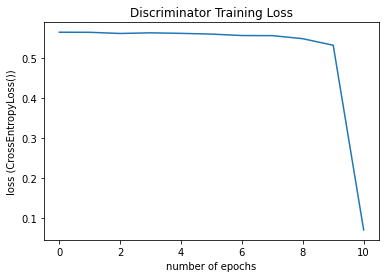

In [26]:
discriminator.plot_loss()

  0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 26/26 [00:06<00:00,  3.85it/s]
/usr/project/xtmp/sc834/al/ActiveLearningShapes/path/to/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


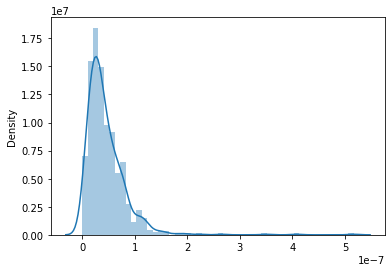

In [27]:
discriminator.plot_distribution(discriminator_training_dir)

In [28]:
# discriminator.show_disc(discriminator_training_dir)

## Go back to CK1 heading if you want to keep querying images

### Deal with some file saving/organization

This section saves some of the results from the discriminator section of our AL. It 
1. saves the pairs identified as good (ie correct segmentations) into the `CorrectSegmentations` subfolder of our `run_dir` (their paths are specified in `saved_oracle_filepaths`).
2. creates a `OracleThresholdedImage_ff` subfolder that has all the same images from the `oracle_query_dir` with rethresholded segmentations based off `oracle_results_thresholds`.
3. `new_saved_oracle_filepaths` are the pairs that were identified as good, but with their paths in the `OracleThresholdedImage_ff` subfolder
4. IF we are using nnunet, then we need to redirect the `new_saved_oracle_filepaths` again, and reprocess to nnunet file/folder format which can be identified using an auto-generated nnunet `task_id` 


NOTE: The below cells (before simplified process) are used to manually threshold oracled images and save them. Not necessary anymore, as ground-truth images are available for segmenter training

In [29]:
# # Space for saving oracle results and pickling data structures
# # saves CORRECT segmentations (determined by the oracle).
# saved_oracle_filepaths = save_active_learning_results(
#     run_dir, oracle_results, oracle_results_thresholds, oracle_query_dir)

# # # not necessary as oracle_results is never even used again in this method.
# # oracle_results = remove_bad_oracle_results(oracle_results)

# # if no images are classified as correct by oracle, print and return
# if len(saved_oracle_filepaths) == 0:
#     print("No oracle results classified as correct.")
# else:
#     print(
#         f"Oracle classifies {len(saved_oracle_filepaths)} images as correct.")


In [30]:
# # For testing - assume all oracled results keys have 1 as the value, saying they are 'correct'

# if os.path.exists(os.path.join(run_dir, "CorrectSegmentations")):
#     if len(os.listdir(os.path.join(run_dir, "CorrectSegmentations"))) == 0:
#         os.rmdir(os.path.join(run_dir, "CorrectSegmentations"))

#         if not os.path.exists(os.path.join(run_dir, "CorrectSegmentations")):
#             os.makedirs(os.path.join(run_dir, "CorrectSegmentations"))

#             for name in ["Irregular", "Round", "Oval"]:
#                 path = os.path.join(os.path.join(run_dir, "CorrectSegmentations"), name)

#                 if not os.path.exists(path):
#                     os.makedirs(path)

#             for key in oracle_results.keys():
#                 path = os.path.join(oracle_query_dir, key + '.npy')
#                 shutil.copyfile(path, os.path.join(run_dir, "CorrectSegmentations", key + '.npy'))


#             for root, dirs, filenames in os.walk(os.path.join(run_dir, "CorrectSegmentations")):
#                 for file in filenames:
#                     img_path = os.path.join(root, file)
#                     saved_oracle_filepaths.append(img_path)

        
# print(saved_oracle_filepaths)
# print(len(saved_oracle_filepaths))

In [31]:
# # Rethresholds all images in the oracle_query_dir - 0.2 threshold if not oracled, custom value for oracled images. 

# segmenter_train_dir = update_dir_with_oracle_info(run_dir, oracle_results_thresholds, oracle_query_dir)

In [32]:
# # this gets filepaths that will then be converted to nnunet format for updating segmenter. 
# # Simply gets images from segmenter_train_dir matching the Patient IDs of saved_oracle_filepaths. 
# # So the images pulled for training are ones that are thresholded from the oracle_results_thresholds custom values. Not ground-truth images.
# new_saved_oracle_filepaths = redirect_saved_oracle_filepaths_to_thresheld_directory(
#     saved_oracle_filepaths, segmenter_train_dir)

# print(new_saved_oracle_filepaths)

In [33]:
# unet = False
# if not unet: 
#     last_task = sorted(glob.glob(os.path.join(os.environ['nnUNet_raw_data_base'], 'nnUNet_raw_data','Task*')))[-1]
#     last_task = last_task.split('nnUNet_raw_data/Task')[-1][:3]
#     task_id = int(last_task) + 1
#     save_files_for_nnunet(task_id, run_id, new_saved_oracle_filepaths) 

## Simplified File Organization
Given that we are using ground-truth images now, rather than manually thresholded images. 

Trying to simplify the above process, now that ideal data exists, removing the need for manual thresholding

In [34]:
unet = False
if not unet: 
    last_task = sorted(glob.glob(os.path.join(os.environ['nnUNet_raw_data_base'], 'nnUNet_raw_data','Task*')))[-1]
    last_task = last_task.split('nnUNet_raw_data/Task')[-1][:3]
    task_id = int(last_task) + 1

new_saved_oracle_filepaths = []

for id in oracle_results:
    patID = id.split('/')[-1]

    for root, dirs, files in os.walk(oracle_query_dir):
        for filename in files:
            if patID in os.path.join(root, filename):
                new_saved_oracle_filepaths.append(os.path.join(root, filename))

print(new_saved_oracle_filepaths)
print("\n === \n")

save_files_for_nnunet(task_id, run_id, new_saved_oracle_filepaths) 

['/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Oval/DP_AEQW_47117_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Oval/DP_AEQW_47116_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Oval/DP_ACZY_23116_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_AALF_5059_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Oval/DP_AHES_118934_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_AJES_186770_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Oval/DP_AEVE_50263_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Irregular/DP_ALYI_48129_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Round/DP_ACGD_14255_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Oval/DP_AJMO_194908_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Oval/DP_ALKN_33137_1.npy', '/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Oval/DP_ALKN_33137_2.npy', '/usr/xtmp/vs196/mammoproj/Data/f

### Update Segmenter

In this section, we update the segmenter (which has been pre-trained off CBIS-DDSM) using the good (`image`, `segmentation`) pairs saved above. 

TUNABLE PARAMETER: 
- `segmenter_update_epochs`: how many epochs to update the segmenter with.

In [35]:
# initialize the model
if unet:
    segmenter = unet_model.unet_model()
    segmenter_train_dir = new_saved_oracle_filepaths
else:
    segmenter = nnunet_model.nnunet_model()
    segmenter_train_dir = os.path.join(os.environ['nnUNet_preprocessed'], f'Task{task_id}_{run_id}')
segmenter.load_model(segmenter_train_dir)

###############################################
I am running the following nnUNet: 2d
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2.nnUNetTrainerV2'>
For that I will be using the following configuration:
num_classes:  1
modalities:  {0: 'RGB'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'nonCT')])
stages...

stage:  0
{'batch_size': 8, 'num_pool_per_axis': [7, 7], 'patch_size': array([640, 640]), 'median_patient_size_in_voxels': array([  1, 519, 518]), 'current_spacing': array([999.,   1.,   1.]), 'original_spacing': array([999.,   1.,   1.]), 'pool_op_kernel_sizes': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'conv_kernel_sizes': [[3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]], 'do_dummy_2D_data_aug': False}

I am using stage 0 from these plans
I am using batch dice + CE loss

I am using data from th

In [36]:
# update the segmenter using the correct image, segmentation pairs
segmenter_update_epochs = SEGMENTER_UPDATE_EPOCHS_INIT ## TUNABLE PARAMETEr
segmenter.update_model(num_epochs = segmenter_update_epochs);

train batches per epoch: 13 	 val: 13 	 batch_size = 8
2023-06-22 17:03:43.110535: lr: 8.5e-05
using pin_memory on device 0
using pin_memory on device 0
2023-06-22 17:04:33.593360: 
epoch:  1000


Epoch 1001/1005: 100%|██████████| 13/13 [00:36<00:00,  2.83s/it, loss=-0.25704208] 


2023-06-22 17:05:10.464178: train loss : -0.0212
2023-06-22 17:05:20.204605: validation loss: -0.1476
2023-06-22 17:05:20.207410: Average global foreground IOU: [0.3245]
2023-06-22 17:05:20.209058: Average global foreground Dice: [0.49]
2023-06-22 17:05:20.210517: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2023-06-22 17:05:20.734754: lr: 6.9e-05
2023-06-22 17:05:20.735626: This epoch took 47.132109 s

2023-06-22 17:05:20.736705: 
epoch:  1001


Epoch 1002/1005: 100%|██████████| 13/13 [00:36<00:00,  2.79s/it, loss=-0.51864535]


2023-06-22 17:05:57.019029: train loss : -0.2566
2023-06-22 17:06:06.736645: validation loss: -0.3811
2023-06-22 17:06:06.739678: Average global foreground IOU: [0.4386]
2023-06-22 17:06:06.741392: Average global foreground Dice: [0.6098]
2023-06-22 17:06:06.742857: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2023-06-22 17:06:07.267598: lr: 5.3e-05
2023-06-22 17:06:07.268502: This epoch took 46.530944 s

2023-06-22 17:06:07.269728: 
epoch:  1002


Epoch 1003/1005: 100%|██████████| 13/13 [00:36<00:00,  2.79s/it, loss=-0.55190337]


2023-06-22 17:06:43.568605: train loss : -0.4718
2023-06-22 17:06:53.320117: validation loss: -0.4591
2023-06-22 17:06:53.322350: Average global foreground IOU: [0.475]
2023-06-22 17:06:53.323841: Average global foreground Dice: [0.6441]
2023-06-22 17:06:53.325532: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2023-06-22 17:06:53.827156: lr: 3.7e-05
2023-06-22 17:06:53.828283: This epoch took 46.557610 s

2023-06-22 17:06:53.829411: 
epoch:  1003


Epoch 1004/1005: 100%|██████████| 13/13 [00:36<00:00,  2.79s/it, loss=-0.36634418]


2023-06-22 17:07:30.152389: train loss : -0.4929
2023-06-22 17:07:39.900412: validation loss: -0.4733
2023-06-22 17:07:39.903563: Average global foreground IOU: [0.4807]
2023-06-22 17:07:39.905124: Average global foreground Dice: [0.6493]
2023-06-22 17:07:39.906620: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2023-06-22 17:07:40.461937: lr: 2e-05
2023-06-22 17:07:40.462904: This epoch took 46.632662 s

2023-06-22 17:07:40.464142: 
epoch:  1004


Epoch 1005/1005: 100%|██████████| 13/13 [00:36<00:00,  2.79s/it, loss=-0.34170833]


2023-06-22 17:08:16.771381: train loss : -0.5222
2023-06-22 17:08:26.503466: validation loss: -0.4589
2023-06-22 17:08:26.505884: Average global foreground IOU: [0.4766]
2023-06-22 17:08:26.507439: Average global foreground Dice: [0.6456]
2023-06-22 17:08:26.509203: (interpret this as an estimate for the Dice of the different classes. This is not exact.)
2023-06-22 17:08:26.968012: lr: 0.0
2023-06-22 17:08:26.968969: This epoch took 46.503970 s

2023-06-22 17:08:27.125455: saving checkpoint...
2023-06-22 17:08:30.436451: done, saving took 3.47 seconds


In [37]:
# potentially save model this iteration if we want. # to be used later 
if unet:
    model_save_path = os.path.join(run_dir, "unetmodel.pth")
else:
    model_save_path = os.path.join(run_dir, 'all', "Iter" + str(iter_num)+".model")
segmenter.save_model(model_save_path)

2023-06-22 17:08:30.500603: saving checkpoint...
2023-06-22 17:08:33.768855: done, saving took 3.29 seconds


### Visualize Segmentations

['/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/Task504_duke-mammo/imagesTr/DP_AGGY_98820_1_0000.nii.gz', '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/Task504_duke-mammo/imagesTr/DP_ABHR_168796_1_0000.nii.gz', '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/Task504_duke-mammo/imagesTr/DP_ACDW_13428_1_0000.nii.gz', '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/Task504_duke-mammo/imagesTr/DP_AGFV_98140_1_0000.nii.gz', '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/Task504_duke-mammo/imagesTr/DP_ABIF_169242_1_0000.nii.gz']
using model stored in  /usr/xtmp/sc834/mammoproj/nnunet_integration_tmp/AllOracleRuns/Run_23_06_22/Iter11/all/..


/usr/project/xtmp/sc834/al/ActiveLearningShapes/path/to/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/project/xtmp/sc834/al/ActiveLearningShapes/path/to/venv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


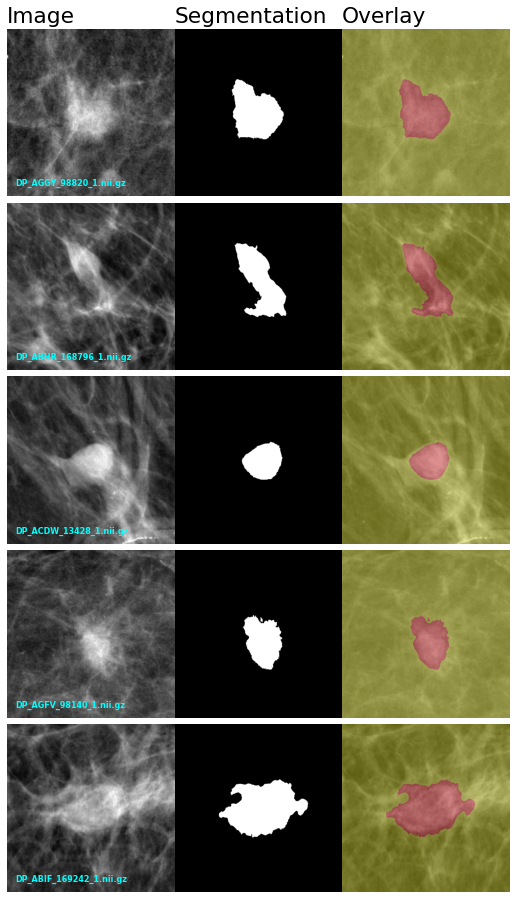

In [38]:
if unet: 
    base_dir = "/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/*"
else:
    base_dir = '/usr/xtmp/jly16/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/Task504_duke-mammo/imagesTr'
filepaths = [str(f) for f in np.random.choice(glob.glob(os.path.join(base_dir, '*')), 5)]

print(filepaths)
segmenter.show_segmentations(filepaths)

### Generate Predictions and Validation
Run the below cell for next stage of active learning (completing the AL Loop)

In [39]:
# # evaluation 1: generate new segmentations of TRAINING images and save them. (This is for the next stage of active learning)

# # Dir for segmentations marked correct by the oracle. We do not want to overwrite the old segmentation, so save them here as an archive
# correct_save_dir = os.path.join(run_dir, "Segmentations_C" )
# # Dir for completely new set of segmentations created by the updated segmenter
# save_dir = os.path.join(run_dir,"Segmentations")

# saved_oracle_filepaths = new_saved_oracle_filepaths

# if unet: 
#     segmentation_folder = discriminator_training_dir
# else:
#     # the path had jly16 originally
#     segmentation_folder = '/usr/xtmp/sc834/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/Task504_duke-mammo/imagesTr'

# segmenter.predict(segmentation_folder, save_dir, correct_save_dir = correct_save_dir, saved_oracle_filepaths = saved_oracle_filepaths)   
# # Push save_dir as the oracle image dir for the next iteration. That's where we populate with unbinarized segmentations from recently trained UNet


In [40]:
# evaluation 2: generate segmentations of VALIDATION and see how accurate our new segmenter is
if unet:
    valid_input_dir =  f"/usr/xtmp/vs196/mammoproj/Data/manualfa/manual_validation/"
else:
    # NOTE: The imagesTs folder has 143 images. imagesTr has 824 images, as expected.
    valid_input_dir = os.path.join(
        os.environ['nnUNet_raw_data_base'], 'nnUNet_raw_data', f"Task504_duke-mammo", 'imagesTs')

# The valid_output_dir is populated by the predict_simple_AL function, within validate. 
# Then the predictions are compared to images in labelsTs
valid_output_dir = os.path.join(run_dir, "ValSegmentations")
validation_metric = segmenter.validate(valid_input_dir, valid_output_dir)
print(f"Metric of new segmenter after active learning is: {validation_metric}.")

using model stored in  /usr/xtmp/sc834/mammoproj/nnunet_integration_tmp/AllOracleRuns/Run_23_06_22/Iter11/all/..
Metric of new segmenter after active learning is: 0.528534506062615.


In [41]:
# NOT Relevent to the model itself. Just some side testing

# Look at a numpy vector prediction from the segmenter - (1, 640, 640). is it already binarized?
# print(img_load1)
# print((img_load1[0,:,:] != img_load1[1,:,:]).sum())
path3 = '/usr/xtmp/sc834/mammoproj/nnunet_integration_tmp/AllOracleRuns/Run_23_06_22/Iter7/initial_segmentations_npy/Irregular/DP_AACA_163_1.npy'
img3 = np.load(path3)
print(img3)

print("===")
# YES

# Look at a testing label 
path4 = "/usr/xtmp/sc834/mammoproj/data/nnUNet_raw_data_base/nnUNet_raw_data/Task504_duke-mammo/imagesTr/DP_AACA_163_1_0000.nii.gz"
img4 = sitk.GetArrayFromImage(sitk.ReadImage(path4))
print(img4)
print("\n ==== \n")

path5 = "/usr/xtmp/vs196/mammoproj/Data/final_dataset/train/Oval/DP_AAEU_173629_1.npy"
img5 = np.load(path5)
print(img5.shape)
print(img5)
# print(img5[0,:,:] == img5[1,:,:])
print((img5[0,:,:] != img5[1,:,:]).sum())

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
===
[[[0.13894239 0.13857209 0.13338782 ... 0.36987409 0.36666201 0.36643258]
  [0.13830747 0.13793783 0.13276287 ... 0.36990626 0.36672558 0.36649839]
  [0.12941857 0.12905824 0.12401359 ... 0.37035672 0.36761556 0.36741976]
  ...
  [0.47867487 0.47928681 0.48785391 ... 0.42514928 0.429503   0.42981398]
  [0.47959183 0.48039412 0.4916263  ... 0.42699424 0.43102432 0.43131218]
  [0.47965732 0.48047322 0.49189576 ... 0.42712603 0.43113298 0.43141919]]]

 ==== 

(2, 224, 224)
[[[0.         0.         0.         ... 0.27966654 0.27051526 0.27141175]
  [0.         0.         0.         ... 0.25073758 0.25144514 0.26267973]
  [0.         0.         0.         ... 0.21747853 0.22832668 0.22661127]
  ...
  [0.16032793 0.16131705 0.20742558 ... 0.27972564 0.29490033 0.33592629]
  [0.15945032 0.16368392 0.18785945 ... 0.24817362 0.29563871 0.29116708]
  [0.15388341 0.1

So the output from the segmenter is already a binarized mask - so thresholding with any value doesn't do anything - leads to the same mask. 

### Plotting Active Learning Metrics